# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 100, 100, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(2000, 100, 100, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(1000, 100, 100, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 100, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,100,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 128)               2560128   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                      

In [34]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [35]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [36]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [37]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [38]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 6s 8ms/step - loss: 6.8721 - mae: 2.0664 - val_loss: 5.0582 - val_mae: 1.7265 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 5s 8ms/step - loss: 5.4280 - mae: 1.8592 - val_loss: 3.7810 - val_mae: 1.5147 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 6s 8ms/step - loss: 5.0155 - mae: 1.7974 - val_loss: 4.6965 - val_mae: 1.7599 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 6s 8ms/step - loss: 5.0646 - mae: 1.8164 - val_loss: 3.9873 - val_mae: 1.5913 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 6s 8ms/step - loss: 4.7538 - mae: 1.7444 - val_loss: 3.8881 - val_mae: 1.5501 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 5s 8ms/step - loss: 4.7748 - mae: 1.7449 - val_loss: 3.3691 - val_mae: 1.4285 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 6s 8ms/step - loss: 4.5918 - mae: 1.7091 - val_loss: 3.1824 - 

700/700 [==============================] - 6s 9ms/step - loss: 3.3766 - mae: 1.4474 - val_loss: 2.2141 - val_mae: 1.1171 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3620 - mae: 1.4430 - val_loss: 2.2207 - val_mae: 1.1182 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3743 - mae: 1.4451 - val_loss: 2.2076 - val_mae: 1.1126 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3224 - mae: 1.4321 - val_loss: 2.1505 - val_mae: 1.0969 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3341 - mae: 1.4342 - val_loss: 2.2046 - val_mae: 1.1101 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3172 - mae: 1.4320 - val_loss: 2.1918 - val_mae: 1.1047 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.3062 - mae: 1.4278 - val_loss: 2.2808 - val_mae

700/700 [==============================] - 5s 8ms/step - loss: 3.0436 - mae: 1.3522 - val_loss: 2.2134 - val_mae: 1.0791 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0032 - mae: 1.3438 - val_loss: 2.0693 - val_mae: 1.0485 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9732 - mae: 1.3389 - val_loss: 2.0256 - val_mae: 1.0291 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9972 - mae: 1.3423 - val_loss: 2.0592 - val_mae: 1.0356 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9856 - mae: 1.3398 - val_loss: 2.0525 - val_mae: 1.0317 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9463 - mae: 1.3318 - val_loss: 2.0450 - val_mae: 1.0303 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0126 - mae: 1.3490 - val_loss: 2.0933 - v

700/700 [==============================] - 6s 8ms/step - loss: 2.7575 - mae: 1.2826 - val_loss: 2.0966 - val_mae: 1.0168 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7532 - mae: 1.2821 - val_loss: 2.1182 - val_mae: 1.0348 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7114 - mae: 1.2739 - val_loss: 2.1121 - val_mae: 1.0362 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.8804 - mae: 1.3105 - val_loss: 2.1454 - val_mae: 1.0458 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.7443 - mae: 1.2826 - val_loss: 2.1779 - val_mae: 1.0547 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7388 - mae: 1.2793 - val_loss: 2.0903 - val_mae: 1.0360 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7319 - mae: 1.2739 - val_loss: 2.0926 - v

700/700 [==============================] - 5s 8ms/step - loss: 2.5200 - mae: 1.2244 - val_loss: 2.2897 - val_mae: 1.0616 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.4870 - mae: 1.2163 - val_loss: 2.1224 - val_mae: 1.0237 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.5238 - mae: 1.2290 - val_loss: 2.1851 - val_mae: 1.0383 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.5173 - mae: 1.2240 - val_loss: 2.2261 - val_mae: 1.0436 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.4686 - mae: 1.2106 - val_loss: 2.1973 - val_mae: 1.0407 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.5415 - mae: 1.2298 - val_loss: 2.1685 - val_mae: 1.0362 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.4725 - mae: 1.2150 - val_loss: 2.0842 - v

700/700 [==============================] - 5s 8ms/step - loss: 2.3420 - mae: 1.1830 - val_loss: 2.2901 - val_mae: 1.0583 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.3605 - mae: 1.1853 - val_loss: 2.3567 - val_mae: 1.0584 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.4129 - mae: 1.1969 - val_loss: 2.2350 - val_mae: 1.0502 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.3616 - mae: 1.1864 - val_loss: 2.3213 - val_mae: 1.0533 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.3292 - mae: 1.1799 - val_loss: 2.2434 - val_mae: 1.0436 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.3255 - mae: 1.1770 - val_loss: 2.2925 - val_mae: 1.0504 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.3865 - mae: 1.1898 - val_loss: 2.3580 - v

700/700 [==============================] - 5s 7ms/step - loss: 2.2758 - mae: 1.1617 - val_loss: 2.2696 - val_mae: 1.0447 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.2623 - mae: 1.1610 - val_loss: 2.3347 - val_mae: 1.0587 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.2542 - mae: 1.1622 - val_loss: 2.8891 - val_mae: 1.2118 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7912 - mae: 1.2914 - val_loss: 2.3645 - val_mae: 1.0863 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.4902 - mae: 1.2188 - val_loss: 2.4051 - val_mae: 1.0824 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.3578 - mae: 1.1869 - val_loss: 2.3015 - val_mae: 1.0498 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.3762 - mae: 1.1944 - val_loss: 2.2571 - v

700/700 [==============================] - 5s 8ms/step - loss: 2.1759 - mae: 1.1391 - val_loss: 2.2901 - val_mae: 1.0427 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.2344 - mae: 1.1542 - val_loss: 2.3906 - val_mae: 1.0678 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.1871 - mae: 1.1396 - val_loss: 2.3985 - val_mae: 1.0569 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.2467 - mae: 1.1589 - val_loss: 2.3380 - val_mae: 1.0430 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.2053 - mae: 1.1456 - val_loss: 2.3045 - val_mae: 1.0422 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.1628 - mae: 1.1378 - val_loss: 2.3762 - val_mae: 1.0740 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.2007 - mae: 1.1458 - val_loss: 2.3163 - v

700/700 [==============================] - 6s 8ms/step - loss: 2.1056 - mae: 1.1208 - val_loss: 2.4334 - val_mae: 1.0614 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.1443 - mae: 1.1329 - val_loss: 2.3686 - val_mae: 1.0635 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.1405 - mae: 1.1299 - val_loss: 2.3811 - val_mae: 1.0563 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.1005 - mae: 1.1186 - val_loss: 2.3489 - val_mae: 1.0511 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.1150 - mae: 1.1207 - val_loss: 2.4609 - val_mae: 1.0788 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.1655 - mae: 1.1347 - val_loss: 2.4942 - val_mae: 1.0766 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.1063 - mae: 1.122

Epoch 494/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.1116 - mae: 1.1188 - val_loss: 2.4731 - val_mae: 1.0700 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0734 - mae: 1.1097 - val_loss: 2.5542 - val_mae: 1.0913 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0344 - mae: 1.1011 - val_loss: 2.3589 - val_mae: 1.0476 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0726 - mae: 1.1124 - val_loss: 2.4005 - val_mae: 1.0547 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0676 - mae: 1.1113 - val_loss: 2.5156 - val_mae: 1.0929 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0141 - mae: 1.0929 - val_loss: 2.4147 - val_mae: 1.0707 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.05

700/700 [==============================] - 5s 8ms/step - loss: 2.0786 - mae: 1.1126 - val_loss: 2.4987 - val_mae: 1.0858 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0533 - mae: 1.1063 - val_loss: 2.4761 - val_mae: 1.0786 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0356 - mae: 1.1049 - val_loss: 2.4834 - val_mae: 1.0794 - lr: 7.5580e-04
Epoch 550/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0559 - mae: 1.1082 - val_loss: 2.4240 - val_mae: 1.0648 - lr: 7.5415e-04
Epoch 551/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0083 - mae: 1.0959 - val_loss: 2.4752 - val_mae: 1.0773 - lr: 7.5250e-04
Epoch 552/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.0415 - mae: 1.1039 - val_loss: 2.3737 - val_mae: 1.0612 - lr: 7.5085e-04
Epoch 553/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.1129 - mae: 1.122

Epoch 601/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9399 - mae: 1.0759 - val_loss: 2.4744 - val_mae: 1.0893 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.9220 - mae: 1.0716 - val_loss: 2.3524 - val_mae: 1.0529 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.9545 - mae: 1.0817 - val_loss: 2.4948 - val_mae: 1.0848 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9475 - mae: 1.0786 - val_loss: 2.4815 - val_mae: 1.0781 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.9534 - mae: 1.0841 - val_loss: 2.4555 - val_mae: 1.0709 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9252 - mae: 1.0740 - val_loss: 2.4234 - val_mae: 1.0614 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.97

700/700 [==============================] - 6s 8ms/step - loss: 1.8949 - mae: 1.0636 - val_loss: 2.5077 - val_mae: 1.0790 - lr: 5.8255e-04
Epoch 655/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9037 - mae: 1.0671 - val_loss: 2.3919 - val_mae: 1.0537 - lr: 5.8090e-04
Epoch 656/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8959 - mae: 1.0634 - val_loss: 2.4513 - val_mae: 1.0685 - lr: 5.7925e-04
Epoch 657/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9066 - mae: 1.0668 - val_loss: 2.4779 - val_mae: 1.0691 - lr: 5.7760e-04
Epoch 658/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8715 - mae: 1.0587 - val_loss: 2.4123 - val_mae: 1.0626 - lr: 5.7595e-04
Epoch 659/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8897 - mae: 1.0600 - val_loss: 2.4912 - val_mae: 1.0833 - lr: 5.7430e-04
Epoch 660/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.9117 - mae: 1.068

Epoch 708/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8391 - mae: 1.0508 - val_loss: 2.4380 - val_mae: 1.0664 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8888 - mae: 1.0599 - val_loss: 2.4786 - val_mae: 1.0861 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8672 - mae: 1.0557 - val_loss: 2.4599 - val_mae: 1.0628 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8742 - mae: 1.0576 - val_loss: 2.5034 - val_mae: 1.0832 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 6s 9ms/step - loss: 1.8772 - mae: 1.0595 - val_loss: 2.4700 - val_mae: 1.0655 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.9062 - mae: 1.0628 - val_loss: 2.3763 - val_mae: 1.0500 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.85

700/700 [==============================] - 6s 9ms/step - loss: 1.8387 - mae: 1.0492 - val_loss: 2.4956 - val_mae: 1.0741 - lr: 4.0600e-04
Epoch 762/1000
700/700 [==============================] - 6s 9ms/step - loss: 1.7868 - mae: 1.0353 - val_loss: 2.4732 - val_mae: 1.0679 - lr: 4.0435e-04
Epoch 763/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7809 - mae: 1.0321 - val_loss: 2.4894 - val_mae: 1.0722 - lr: 4.0270e-04
Epoch 764/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8025 - mae: 1.0392 - val_loss: 2.4593 - val_mae: 1.0655 - lr: 4.0105e-04
Epoch 765/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8121 - mae: 1.0413 - val_loss: 2.4486 - val_mae: 1.0588 - lr: 3.9940e-04
Epoch 766/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.7975 - mae: 1.0348 - val_loss: 2.4400 - val_mae: 1.0649 - lr: 3.9775e-04
Epoch 767/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.8275 - mae: 1.045

700/700 [==============================] - 6s 8ms/step - loss: 1.7794 - mae: 1.0341 - val_loss: 2.4634 - val_mae: 1.0702 - lr: 3.1855e-04
Epoch 815/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7923 - mae: 1.0378 - val_loss: 2.4761 - val_mae: 1.0692 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.8497 - mae: 1.0494 - val_loss: 2.4992 - val_mae: 1.0758 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7724 - mae: 1.0302 - val_loss: 2.4857 - val_mae: 1.0706 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.8067 - mae: 1.0385 - val_loss: 2.4322 - val_mae: 1.0614 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7744 - mae: 1.0313 - val_loss: 2.5510 - val_mae: 1.0774 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7903 - mae: 1.035

Epoch 868/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7719 - mae: 1.0319 - val_loss: 2.4516 - val_mae: 1.0632 - lr: 2.2945e-04
Epoch 869/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.7851 - mae: 1.0318 - val_loss: 2.4147 - val_mae: 1.0575 - lr: 2.2780e-04
Epoch 870/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7785 - mae: 1.0285 - val_loss: 2.4303 - val_mae: 1.0559 - lr: 2.2615e-04
Epoch 871/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.7426 - mae: 1.0170 - val_loss: 2.4569 - val_mae: 1.0646 - lr: 2.2450e-04
Epoch 872/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7623 - mae: 1.0263 - val_loss: 2.4386 - val_mae: 1.0666 - lr: 2.2285e-04
Epoch 873/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7601 - mae: 1.0270 - val_loss: 2.5117 - val_mae: 1.0738 - lr: 2.2120e-04
Epoch 874/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.76

700/700 [==============================] - 6s 8ms/step - loss: 1.7331 - mae: 1.0173 - val_loss: 2.4823 - val_mae: 1.0697 - lr: 1.4200e-04
Epoch 922/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7298 - mae: 1.0170 - val_loss: 2.4413 - val_mae: 1.0626 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7250 - mae: 1.0150 - val_loss: 2.4403 - val_mae: 1.0628 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7087 - mae: 1.0132 - val_loss: 2.4563 - val_mae: 1.0593 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7393 - mae: 1.0199 - val_loss: 2.4512 - val_mae: 1.0616 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7383 - mae: 1.0187 - val_loss: 2.4384 - val_mae: 1.0582 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7169 - mae: 1.012

Epoch 975/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7141 - mae: 1.0119 - val_loss: 2.4777 - val_mae: 1.0672 - lr: 5.2900e-05
Epoch 976/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7143 - mae: 1.0132 - val_loss: 2.4521 - val_mae: 1.0595 - lr: 5.1250e-05
Epoch 977/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7096 - mae: 1.0110 - val_loss: 2.4339 - val_mae: 1.0582 - lr: 4.9600e-05
Epoch 978/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.7387 - mae: 1.0193 - val_loss: 2.4476 - val_mae: 1.0605 - lr: 4.7950e-05
Epoch 979/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.6969 - mae: 1.0079 - val_loss: 2.4578 - val_mae: 1.0627 - lr: 4.6300e-05
Epoch 980/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.7296 - mae: 1.0159 - val_loss: 2.4588 - val_mae: 1.0621 - lr: 4.4650e-05
Epoch 981/1000
700/700 [==============================] - 6s 8ms/step - loss: 1.74

# Analizamos accuracy y loss

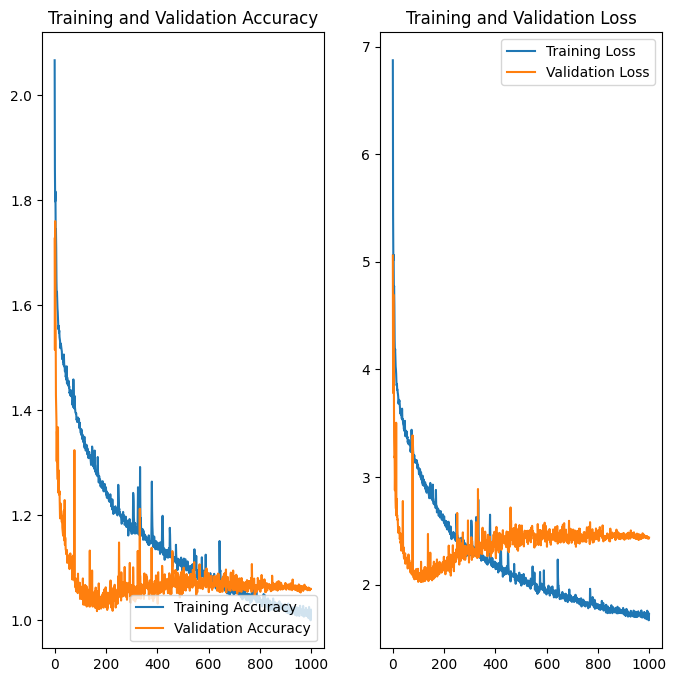

In [39]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [40]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 100,200/historyconvcampvec100.csv', index=False)

# Guardamos el modelo

In [41]:
path_to_save = '../../../Modelos con ruido/Modelos 100,200/'

In [42]:
model.save(path_to_save + '/convolucionalcv100.h5')

# Importamos el modelo

In [43]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [44]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 100,200/convolucionalcv100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [82]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)

    t1 = 0

    NI, NJ = Y1.shape
    u, v = np.zeros((NI, NJ)), np.zeros((NI, NJ))

    for i in range(NI):
        for j in range(NJ):
            # asignar a cada ODE a un elemento de vector
            X = Y1[i, j]
            Y = Y2[i, j]
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            # definimos cada ODE
            dX_dt=(a1)/(1+Y**(n))-(d1)*X+b1+noise1
            dY_dt=(a2)/(1+X**(n))-(d2)*Y+b2+noise2

            u[i, j], v[i, j] = dX_dt, dY_dt
    
    u1,v1 = u,v
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[10, 5, 4, 5, 10, 7, 0]


In [83]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [84]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 13ms/step
[[3. 6. 6. 4. 9. 6. 0.]]


## Encontramos puntos de equilibro datos reales

In [85]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(0.9, 0.9285714285714286)


## Graficamos con los coeficientes reales

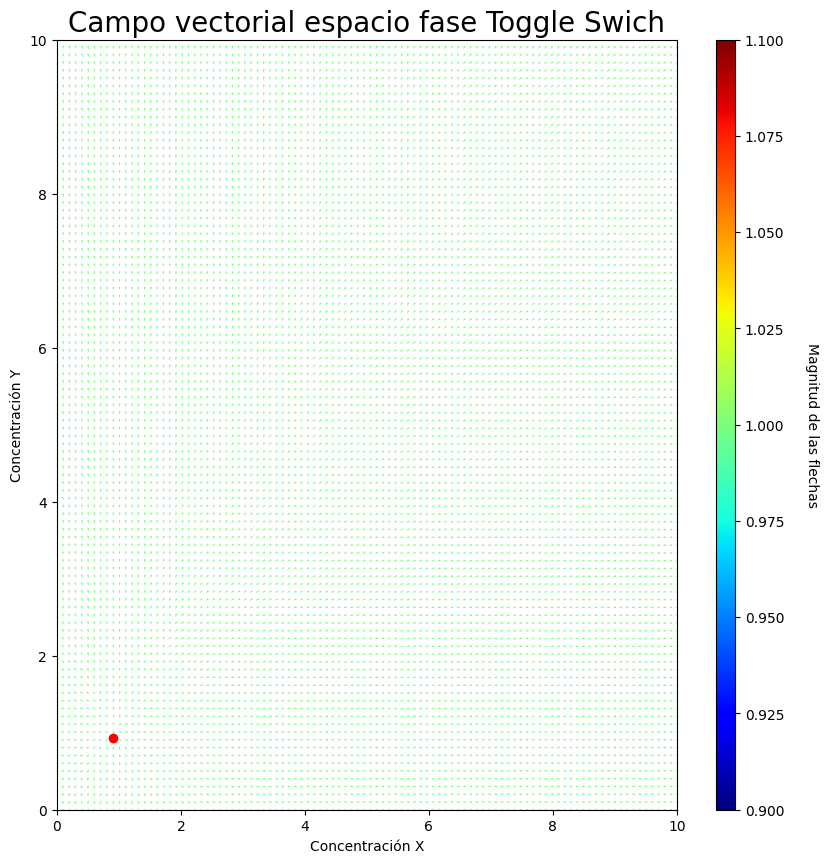

In [96]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values = primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy', pivot='mid', cmap='jet')  # Añadir una cmap
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

cbar = plt.colorbar(Q, aspect=40, pad=0.05)  # Agregar la colorbar
cbar.set_label('Magnitud de las flechas', rotation=270, labelpad=25)

plt.show()

## Encontramos puntos de equilibro datos predecidos

In [87]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(0.8333333333333334, 1.5000000000000002)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

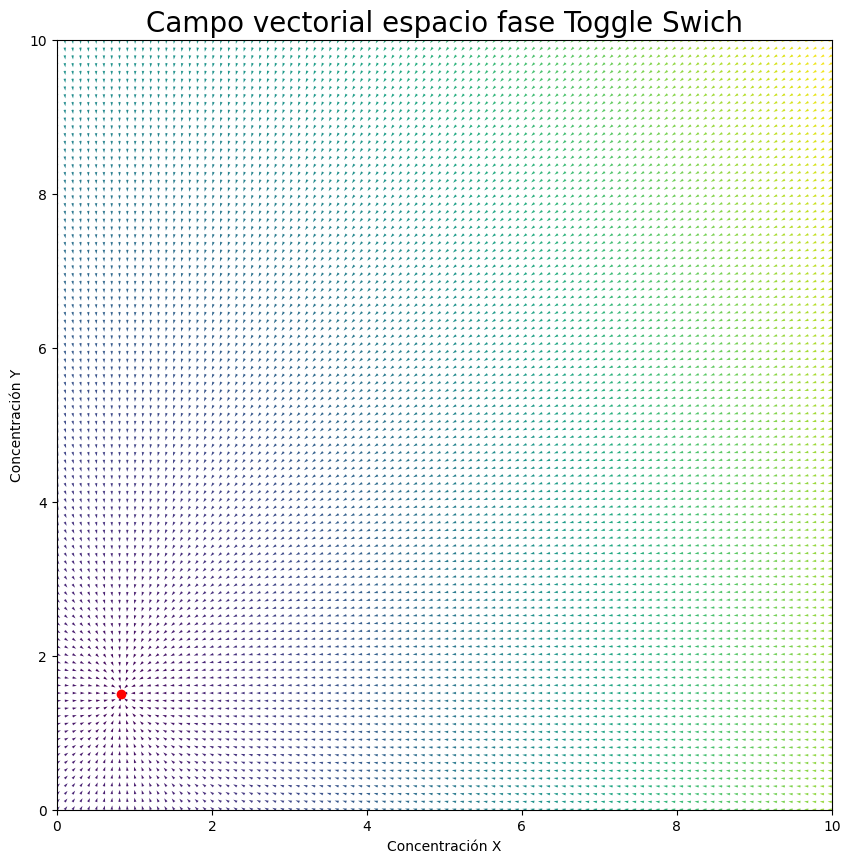

In [88]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

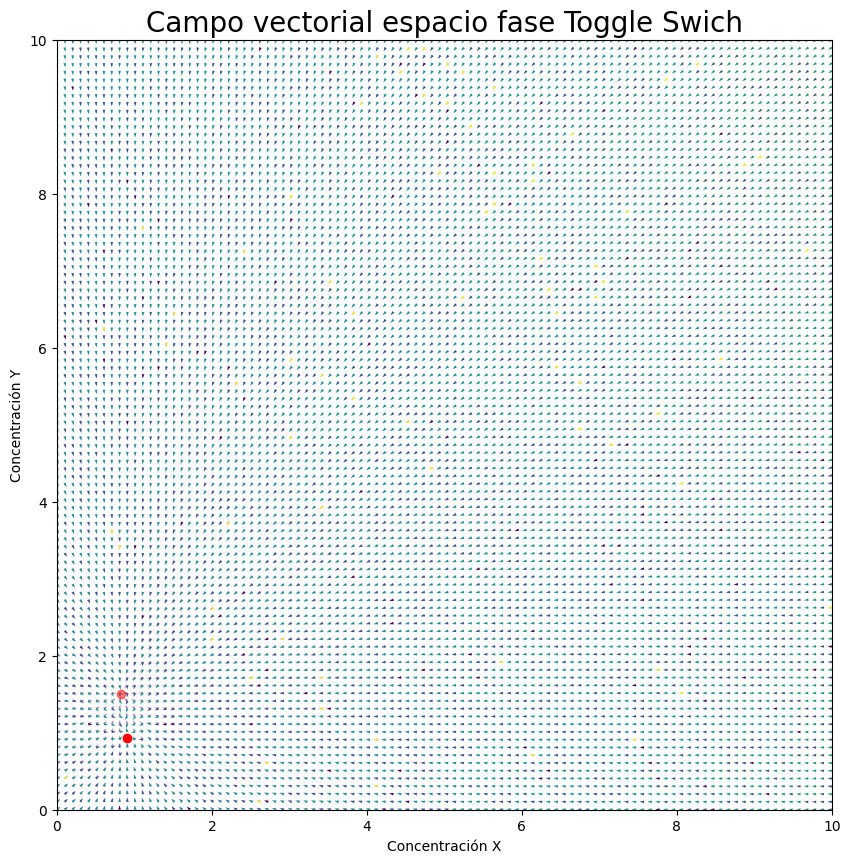

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

58.16072010306914


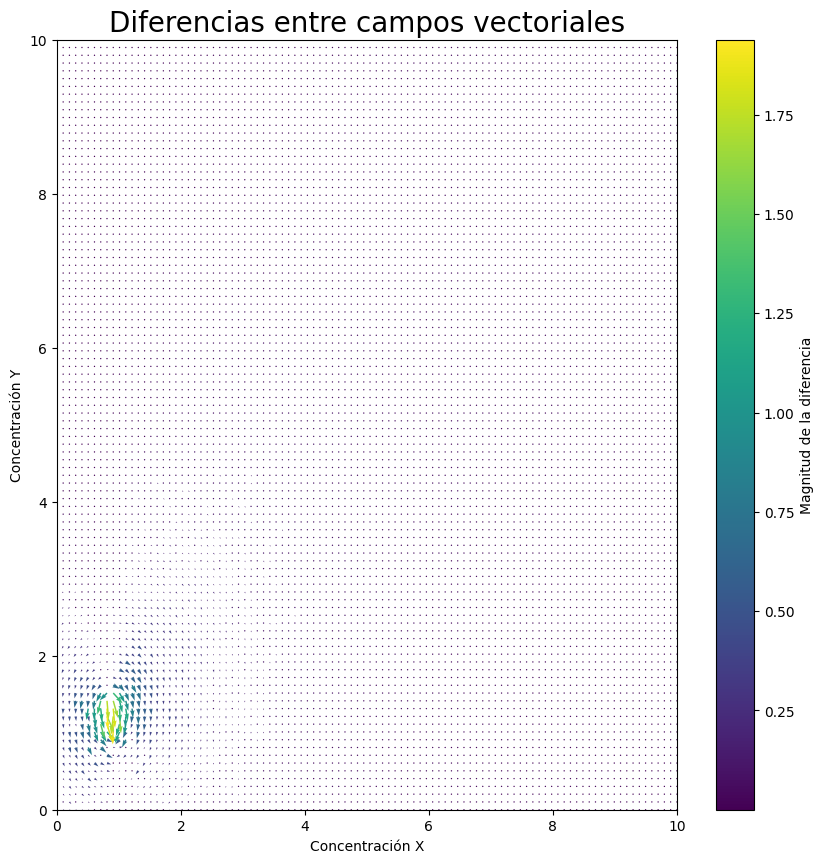

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [91]:
M_diff.mean()

0.07803872278178091

## Errores relativos

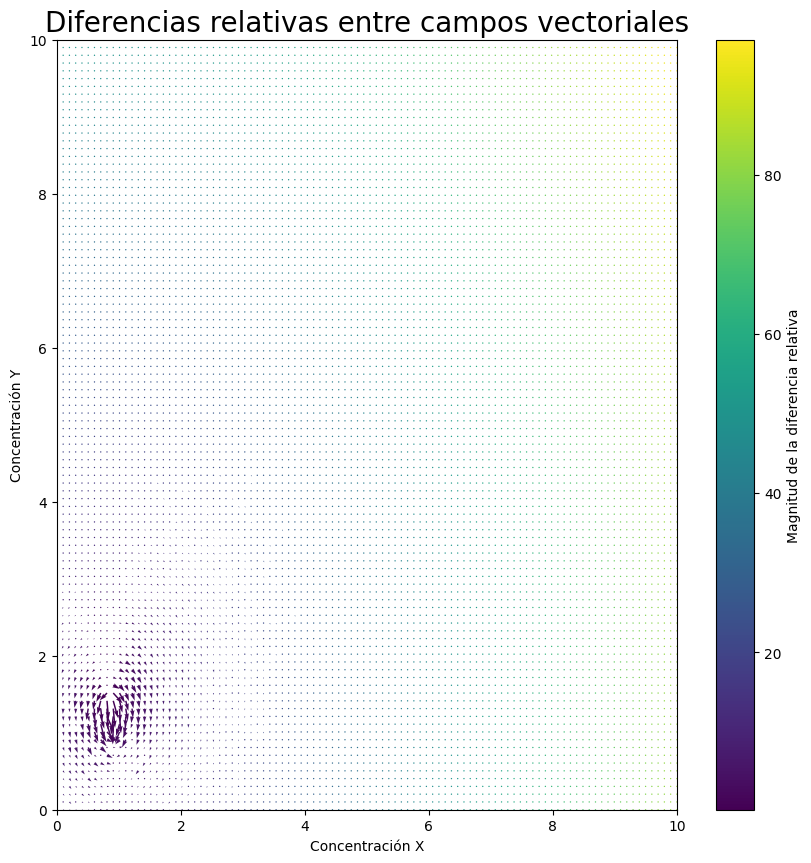

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [93]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 96.99096926286636
El valor de u1 en el error relativo máximo es: -0.8251264485353021
El valor de u1pred en el error relativo máximo es: -82.5
El valor de v1 en el error relativo máximo es: -0.5649480895865737
El valor de v1pred en el error relativo máximo es: -51.0


In [94]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

96.99097896196328